### Training of modified U-Net for Optic Disc on RIM-ONE v3 database (cross-validation fold #0).

512 px cropped by Optic Disc area and resized to 128 px images were used.

You can either train your model or upload a pre-trained one from:
*../models_weights/01.03,10:33,OD Cup, U-Net light on RIM-ONE v3 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5*

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
from sklearn.cross_validation import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2
import h5py
from tqdm import tqdm_notebook
import mahotas as mh
from IPython.display import display
from dual_IDG import DualImageDataGenerator

/home/artem/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, \
    Lambda, UpSampling2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [4]:
K.set_image_dim_ordering('th')

In [5]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.cast(K.greater(X_fl, 0.5), 'float32')
    Y_fl = K.cast(K.greater(Y_fl, 0.5), 'float32')

    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), K.ones_like(union), union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [6]:
def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.cast(K.greater(y_true, 0.5), 'float32')
    y_pred_f = K.cast(K.greater(y_pred, 0.5), 'float32')
    return dice(y_true_f, y_pred_f)

In [7]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

In [9]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'all_data.hdf5'), 'r')
#h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'RIM_ONE_v3.hdf5'), 'r')

### U-Net architecture

<img src="../pics/u_net_arch.png" width=80%>

In [10]:
def get_unet_light(img_rows=256, img_cols=256):
    inputs = Input((3, img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    conv1 = Dropout(0.3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)
    conv9 = Dropout(0.3)(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)
    #conv10 = Flatten()(conv10)

    model = Model(input=inputs, output=conv10)

    return model

In [11]:
model = get_unet_light(img_rows=128, img_cols=128)
model.compile(optimizer=SGD(lr=3e-4, momentum=0.95),
              loss=log_dice_loss,
              metrics=[mean_IOU_gpu, dice_metric])

/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 128, 128)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 128) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 128, 128) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 128, 128) 9248        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

#### RIM-ONE v3

Accessing data, preparing train/validation sets division:

In [13]:
# Loading full images of desired resolution:
X = h5f['RIM-ONE v3/512 px/images']
Y = h5f['RIM-ONE v3/512 px/cup']
disc_locations = h5f['RIM-ONE v3/512 px/disc_locations']

In [14]:
X, Y

(<HDF5 dataset "images": shape (159, 512, 512, 3), type "|u1">,
 <HDF5 dataset "cup": shape (159, 512, 512, 1), type "|u1">)

In [15]:
n_folds = 5
train_idx_cv, test_idx_cv = [], []

for _train_idx, _test_idx in KFold(X.shape[0], n_folds):
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)

In [16]:
#train_idx = h5f['RIM-ONE v3/train_idx_driu']
#test_idx = h5f['RIM-ONE v3/test_idx_driu']

train_idx = train_idx_cv[0]
test_idx = test_idx_cv[0]

In [17]:
len(X), len(train_idx), len(test_idx)

(159, 127, 32)

#### Generator of augmented data:

In [18]:
train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                   zoom_range=(0.8, 1.2),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()

#### Preprocessing function and data generator:

In [19]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    batch_y = batch_y / 255.0
    
    if train_or_test == 'train':
        batch_X, batch_y = next(train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    elif train_or_test == 'test':
        batch_X, batch_y = next(test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False))
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i]) 
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, resize_to=128, train_or_test='train', batch_size=3, return_orig=False, stationary=False):
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
                   for i in idx]
        batch_X = [np.rollaxis(img, 2) for img in batch_X]
        batch_X = [sp.misc.imresize(img, (resize_to, resize_to)) for img in batch_X]
        batch_X = np.array(batch_X).copy()
        
        batch_y = [y[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
                   for i in idx]
        batch_y = [img[..., 0] for img in batch_y]
        batch_y = [sp.misc.imresize(img, (resize_to, resize_to))[..., None] for img in batch_y]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

Testing the data generator and generator for augmented data:

In [20]:
gen = data_generator(X, Y, 128, 'train', batch_size=1)
batch = next(gen)
batch[0].shape

/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/artem/.local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


(1, 3, 128, 128)

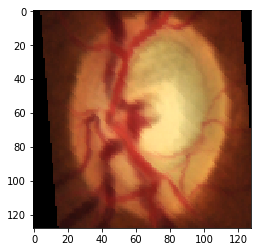

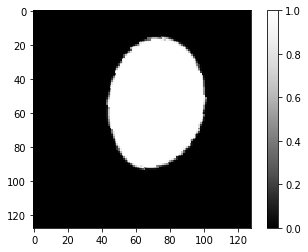

In [21]:
fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
#plt.colorbar(mappable=fig)
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.colorbar(); plt.show()

In [22]:
arch_name = "OD Cup, U-Net light on RIM-ONE v3 512 px cropped to OD 128 px fold 0, SGD, log_dice loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))

In [23]:
weights_folder

'../models_weights/02.01,15:43,OD Cup, U-Net light on RIM-ONE v3 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/'

In [24]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


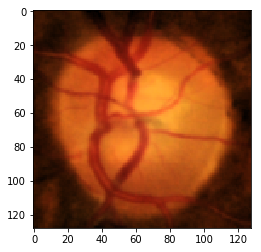

((32, 3, 128, 128), (32, 1, 128, 128))


In [25]:
X_valid, Y_valid = next(data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True))
plt.imshow(np.rollaxis(X_valid[0], 0, 3)); plt.show()
print(X_valid.shape, Y_valid.shape)

### Training

If a pretrained model needs to be used, first run "Loading model" section below and then go the "Comprehensive visual check", skipping this section.

In [ ]:
history = model.fit_generator(data_generator(X, Y, train_or_test='train', batch_size=1), 
                              samples_per_epoch=len(train_idx),
                              max_q_size=1,
                              
                              validation_data=(X_valid, Y_valid),
                              #validation_data=data_generator(X, Y, train_or_test='test', batch_size=1),
                              #nb_val_samples=100,
                              
                              nb_epoch=500, verbose=1,
                              
                              callbacks=[CSVLogger(folder(weights_folder) + '/' + 'training_log.csv', append=True),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=50),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)])

### Comprehensive visual check

In [28]:
# Function for rescaling cropped cup region and putting it back into original image,
# and resizing the result to resulting_size.
# Not needed if a model is trained on full (not cropped) images.

def rescale_back(cropped, rectangle, orig_size=(512, 512), resulting_size=(256, 256)):
    # `cropped` must be a grayscale image 
    # rectangle must be an iterable (min_i, min_j, max_i, max_j)
    
    min_i, min_j, max_i, max_j = rectangle
    part_rescaled = sp.misc.imresize(cropped, (max_i - min_i + 1, max_j - min_j + 1))
    resulting_img = np.zeros(orig_size, dtype=cropped.dtype)
    resulting_img[min_i:max_i + 1, min_j:max_j + 1] = part_rescaled
    resulting_img = sp.misc.imresize(resulting_img, resulting_size)
    return resulting_img

image #0


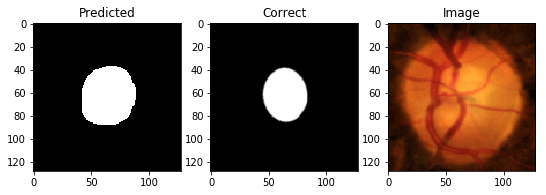

IOU: 0.693239152431
Dice: 0.830236199302
image #1


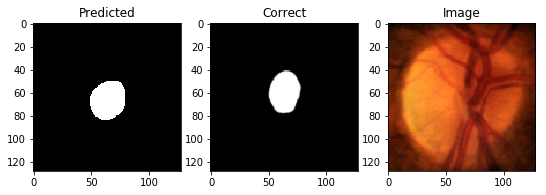

IOU: 0.570029377937
Dice: 0.736633356306
image #2


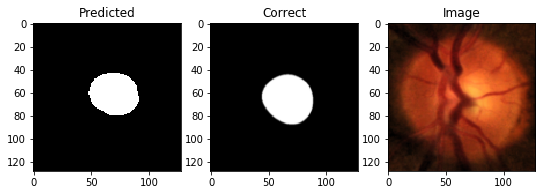

IOU: 0.7130215168
Dice: 0.843655052639
image #3


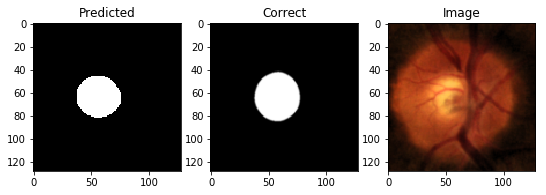

IOU: 0.812785387039
Dice: 0.911701504219
image #4


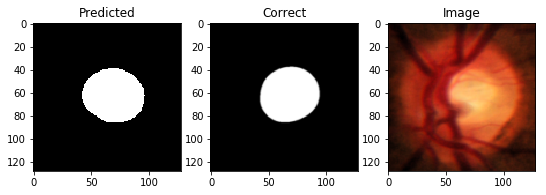

IOU: 0.891293883324
Dice: 0.951246905722
image #5


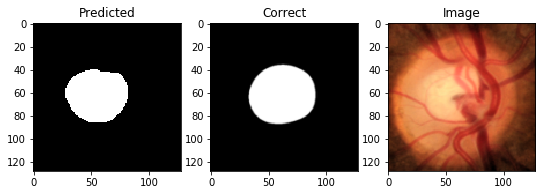

IOU: 0.704626321793
Dice: 0.836290840357
image #6


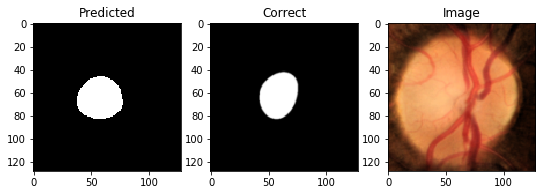

IOU: 0.742243409157
Dice: 0.864632199205
image #7


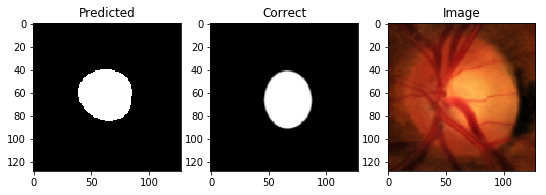

IOU: 0.711558878422
Dice: 0.841833652719
image #8


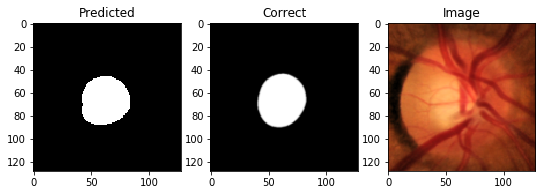

IOU: 0.904020726681
Dice: 0.961737900581
image #9


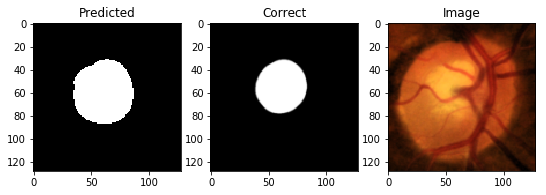

IOU: 0.682874381542
Dice: 0.820771857456
image #10


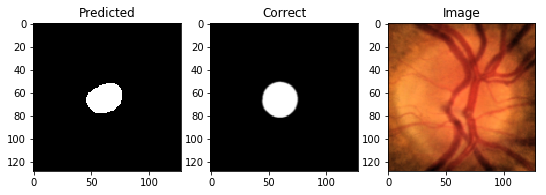

IOU: 0.7578125
Dice: 0.881062367947
image #11


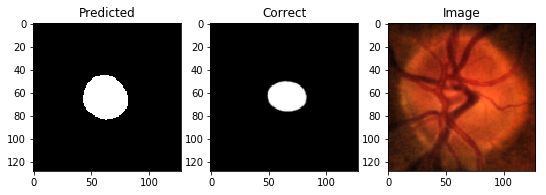

IOU: 0.564146161079
Dice: 0.73299229828
image #12


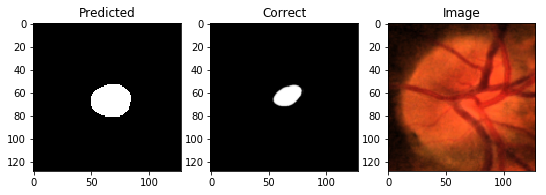

IOU: 0.400503784418
Dice: 0.580248476442
image #13


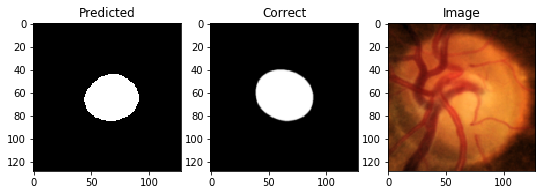

IOU: 0.790710687637
Dice: 0.891221349721
image #14


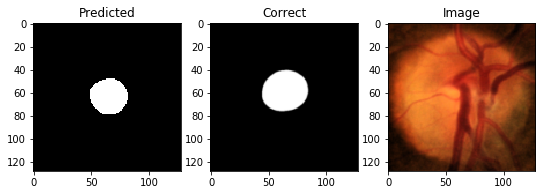

IOU: 0.62478774786
Dice: 0.783257911343
image #15


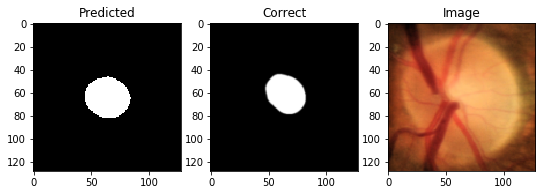

IOU: 0.738825619221
Dice: 0.862843487263
image #16


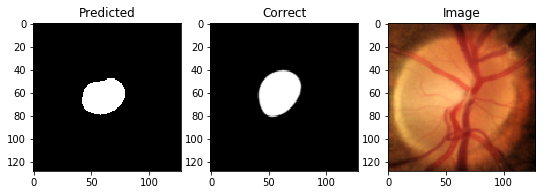

IOU: 0.716481626034
Dice: 0.848622498861
image #17


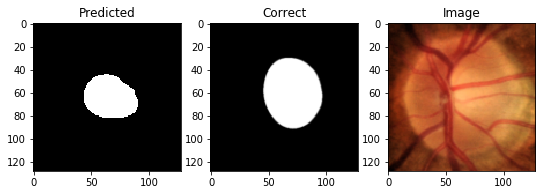

IOU: 0.537059545517
Dice: 0.707412660209
image #18


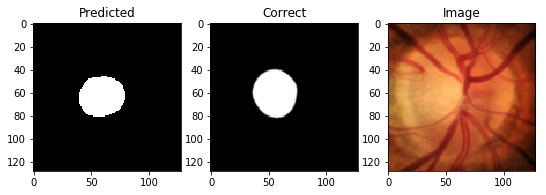

IOU: 0.741071403027
Dice: 0.86331818741
image #19


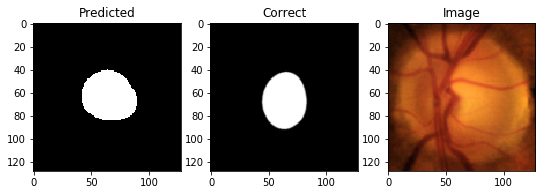

IOU: 0.707076251507
Dice: 0.838681977071
image #20


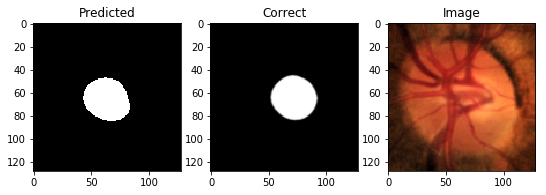

IOU: 0.550166130066
Dice: 0.72211772978
image #21


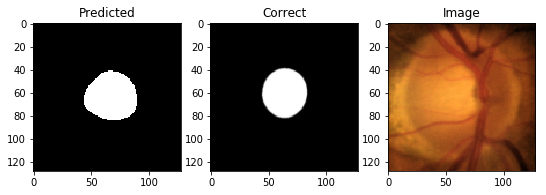

IOU: 0.736874639988
Dice: 0.861107663477
image #22


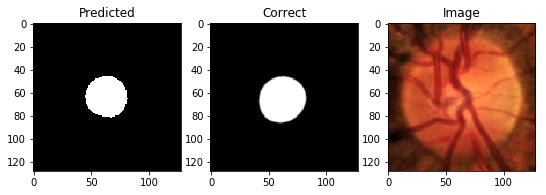

IOU: 0.792586743832
Dice: 0.895806707326
image #23


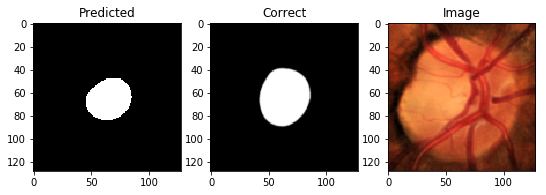

IOU: 0.65032106638
Dice: 0.802449592447
image #24


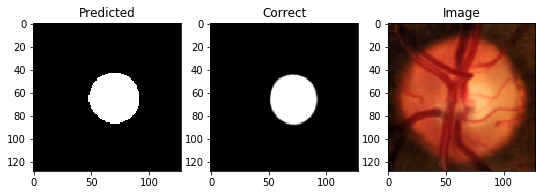

IOU: 0.867273926735
Dice: 0.937756289912
image #25


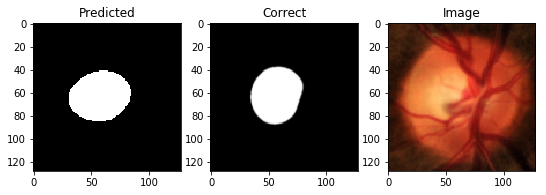

IOU: 0.805924415588
Dice: 0.9031888323
image #26


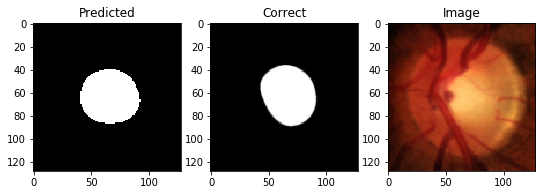

IOU: 0.837452471256
Dice: 0.922055835462
image #27


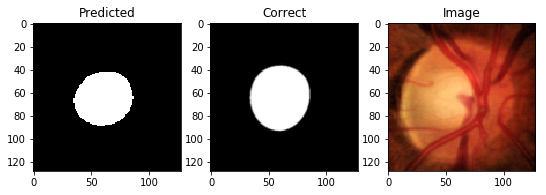

IOU: 0.823992967606
Dice: 0.913174314611
image #28


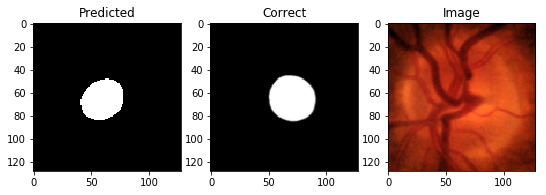

IOU: 0.465295642614
Dice: 0.647131728617
image #29


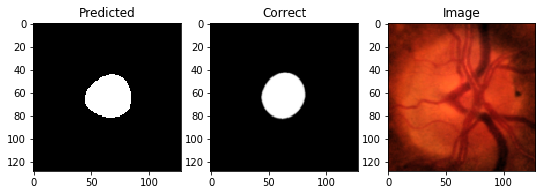

IOU: 0.826465904713
Dice: 0.916658868075
image #30


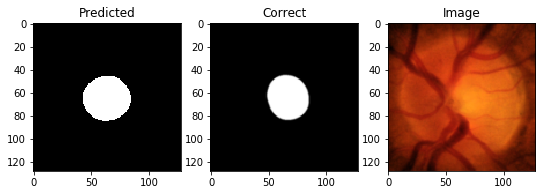

IOU: 0.78286999464
Dice: 0.891788443675
image #31


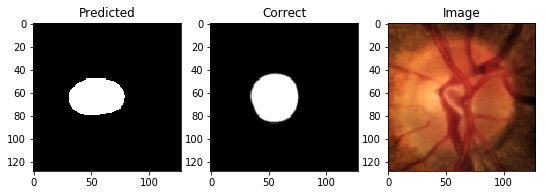

IOU: 0.738522946835
Dice: 0.862471200331


In [29]:
pred_iou, pred_dice = [], []

if K.backend() == 'tensorflow':
    sess = K.get_session()

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = (model.predict(batch_X)[0, 0] > 0.5).astype(np.float64)
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    # mean filtering:
    #pred = mh.mean_filter(pred, Bc=mh.disk(10)) > 0.5
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    if K.backend() == 'tensorflow':
        cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval(session=sess)
        cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval(session=sess)
    else:
        cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval()
        cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval()
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

Acquiring scores for the validation set:

In [30]:
print(np.mean(pred_iou))
print(np.mean(pred_dice))

0.71506
0.839503371533


Showing the best and the worst cases:

/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys
/home/artem/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


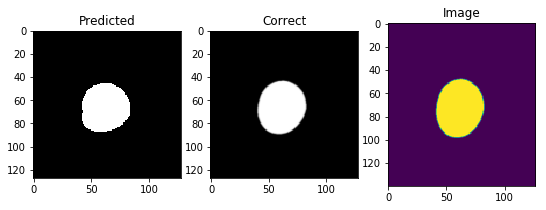

IOU: 0.904020726681, Dice: 0.961737900581 (best)


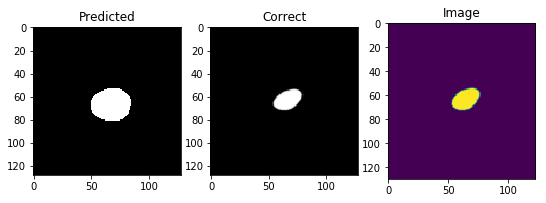

IOU: 0.400503784418, Dice: 0.580248476442 (worst)


In [31]:
def show_img_pred_corr(i, file_suffix):    # i is index of image in test_idx
    img_no = test_idx[i]
    idx = [img_no]
    batch_X = [X[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
               for i in idx]
    batch_X = [np.rollaxis(img, 2) for img in batch_X]
    batch_X = [sp.misc.imresize(img, (128, 128)) for img in batch_X]
    batch_X = np.array(batch_X).copy()
    img = batch_X[0]

    batch_y = [Y[i][disc_locations[i][0]:disc_locations[i][2], disc_locations[i][1]:disc_locations[i][3]] 
               for i in idx]
    batch_y = [img[..., 0] for img in batch_y]
    batch_y = [sp.misc.imresize(img, (128, 128))[..., None] for img in batch_y]
    batch_y = np.array(batch_y).copy()
    
    batch_X = tf_to_th_encoding(batch_X)
    batch_y = tf_to_th_encoding(batch_y)
    batch_X, batch_y = preprocess(batch_X, batch_y, 'test')
    
    pred = model.predict(batch_X)[0, 0] > 0.5
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(img)
    ax.set_title('Image')
    plt.show()
    
    plt.imsave('od_cup_rim_one_v3_fold_0_{}_case_image.png'.format(file_suffix), img)
    plt.imsave('od_cup_rim_one_v3_fold_0_{}_case_pred.png'.format(file_suffix), pred, cmap=plt.cm.Greys_r)
    plt.imsave('od_cup_rim_one_v3_fold_0_{}_case_corr.png'.format(file_suffix), corr, cmap=plt.cm.Greys_r)


best_idx = np.argmax(pred_iou)
worst_idx = np.argmin(pred_iou)
show_img_pred_corr(best_idx, 'best')
print('IOU: {}, Dice: {} (best)'.format(pred_iou[best_idx], pred_dice[best_idx]))
show_img_pred_corr(worst_idx, 'worst')
print('IOU: {}, Dice: {} (worst)'.format(pred_iou[worst_idx], pred_dice[worst_idx]))

### Loading model

In [27]:
load_model = True   # lock
if not load_model:
    print('load_model == False')
else:
    # specify file:
    #model_path = '../models_weights/01.11,22:38,U-Net on DRIONS-DB 256 px, Adam, augm, log_dice loss/' \
    #    'weights.ep-20-val_mean_IOU-0.81_val_loss_0.08.hdf5'
    
    # or get the most recent file in a folder:
    model_folder = weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights', '01.03,10_33,OD Cup, U-Net light on RIM-ONE v3 512 px cropped to OD 128 px fold 0, SGD, log_dice loss')
    
    #model_folder = weights_folder
    
    model_path = max(glob.glob(os.path.join(model_folder, '*.hdf5')), key=os.path.getctime)
    if load_model and not os.path.exists(model_path):
        raise Exception('`model_path` does not exist')
    print('Loading weights from', model_path)

    if load_model:
        #with open(model_path + ' arch.json') as arch_file:
        #    json_string = arch_file.read()
        #new_model = model_from_json(json_string)
        model.load_weights(model_path)
    
    # Reading log statistics
    import pandas as pd
    
    log_path = os.path.join(model_folder, 'training_log.csv')
    if os.path.exists(log_path):
        log = pd.read_csv(log_path)
        if log['epoch'].dtype != 'int64':
            log = log.loc[log.epoch != 'epoch']
        print('\nmax val mean IOU: {}, at row:'.format(log['val_mean_IOU_gpu'].max()))
        print(log.loc[log['val_mean_IOU_gpu'].argmax()])
        if 'val_dice_metric' in log.columns:
            print('\n' + 'max val dice_metric: {}, at row:'.format(log['val_dice_metric'].max()))
            print(log.loc[log['val_dice_metric'].argmax()])

('Loading weights from', '../models_weights/01.03,10_33,OD Cup, U-Net light on RIM-ONE v3 512 px cropped to OD 128 px fold 0, SGD, log_dice loss/last_checkpoint.hdf5')

max val mean IOU: 0.714873954654, at row:
epoch               245.000000
dice_metric           0.799437
loss                  0.163397
mean_IOU_gpu          0.675642
val_dice_metric       0.828447
val_loss              0.134474
val_mean_IOU_gpu      0.714874
Name: 245, dtype: float64

max val dice_metric: 0.828446704894, at row:
epoch               245.000000
dice_metric           0.799437
loss                  0.163397
mean_IOU_gpu          0.675642
val_dice_metric       0.828447
val_loss              0.134474
val_mean_IOU_gpu      0.714874
Name: 245, dtype: float64
